# Cart pole #

## Imports ##

In [1]:
import gym
import tensorflow as tf
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import time

C:\Users\wocjan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Environment ##

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

## Hyperparameters ##

Network has to be complex enough. Batch size has to be large enough.

In [3]:
# Environment parameters
state_size = 4
action_size = 2

# Training parameters
train_episodes = 500          # number of episodes to train
max_steps = 200                # max number of step in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
epsilon_start = 1.0            # exploration probability at start
epsilon_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0002            # exponential decay rate for exploration prob

# Q neural network parameters
first_layer_size = 128         # number of neurons in first hidden layer
second_layer_size = 64         # number of neurons in second hidden layer
learning_rate = 0.0001         # learning rate

# Memory parameters
memory_size = 20000             # memory capacity
batch_size = 100                # experience mini-batch size
pretrain_length = memory_size   # number experiences to pretrain the memory

## Experience replay ##

In [4]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        random_index_list = np.random.choice(np.arange(len(self.buffer)), 
                               size = batch_size, 
                               replace = False)
        return [self.buffer[index] for index in random_index_list]

### Prepopulate the experience memory ###

In [5]:
# Create empty queue
memory = Memory(max_size = memory_size)

# Make a bunch of random actions and store the experiences
state = env.reset()

for _ in range(pretrain_length):
    # Take a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    memory.add((state, action, reward, next_state, done))
    
    if done:
        # Start new episode
        state = env.reset()
    else:
        # Go to next state
        state = next_state

## Neural network ##

In [6]:
class QNN:
    def __init__(self, 
                 state_size = state_size, 
                 action_size = action_size, 
                 first_layer_size = 128,
                 second_layer_size = 64,
                 learning_rate = 0.01, 
                 name = 'qnn'):
        
        # state inputs to the Q-network
        with tf.variable_scope(name):
    
            # Prediction part of the QNN
            # computes q(s, a) for given state s and all actions a
            # so best action can be determined as argmax_a q(s, a)
    
            # Input layer, state s is input
            self.state = tf.placeholder(tf.float32, 
                                        [None, state_size], 
                                        name = 'state')
            
            # First hidden layer, ReLU activation
            self.first_layer = tf.contrib.layers.fully_connected(self.state, 
                                                                 first_layer_size)
            # Second hidden layer, ReLU activation
            self.second_layer = tf.contrib.layers.fully_connected(self.first_layer, 
                                                                  second_layer_size)

            # Output layer, linear activation, q_vector(s, a) is output
            self.q_vector = tf.contrib.layers.fully_connected(self.second_layer,
                                                              action_size,
                                                              activation_fn = None)
    
            # Training part of the Q-network
            # uses observed transition (s, a, r, s') to update the weights of the network
    
            # Action a
            self.action = tf.placeholder(tf.int32, 
                                         [None], 
                                         name = 'action')
            # One-hot encoded action a 
            #
            # encoded_action_vector = [1, 0] if action a = 0
            # encoded_action_vector = [0, 1] if action a = 1
            encoded_action_vector = tf.one_hot(self.action, 
                                               action_size)
    
            # Target Q value for training
            # target_q_value = r + gamma * max_a' q(s', a') if state s' is non-terminal
            # target_q_value = r                            if state s' is terminal
            self.target_q_value = tf.placeholder(tf.float32, 
                                                 [None], 
                                                 name = 'target_q_value')
    
            # Q value for training
            # q_value = q(s, a)
            # It is important that everything is computed using linear-algebraic operations
            # to leverage vectorization etc.
            q_value = tf.reduce_sum(tf.multiply(self.q_vector, encoded_action_vector), 
                                         axis = 1)
            # Loss
            self.loss = tf.reduce_mean(tf.square(self.target_q_value - q_value))
            
            # Optimizer
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            
    # get best action 
    def get_action(self, state):
        feed_dict = { self.state : np.array([state]) } 
        q_vector = sess.run(self.q_vector, 
                            feed_dict = feed_dict)
        return np.argmax(q_vector)
        
    # train based on a batch of data from 
    def update(self):    
        # Sample mini-batch from memory
        batch = memory.sample(batch_size)
        # some Python magic
        state, action, reward, next_state, done = zip(*batch)
    
        state = np.array(state)
        action = np.array(action)
        reward = np.array(reward)
        next_state = np.array(next_state)
        mask = 1.0 - np.array(done)
    
        next_q_vector = sess.run(self.q_vector, 
                                 feed_dict = { 
                                     self.state : next_state 
                                 })
        
        target_q_value = reward + gamma * mask * np.max(next_q_vector, axis = 1)

        sess.run([self.loss, self.optimizer],
                 feed_dict = {
                               self.state          : state,
                               self.target_q_value : target_q_value,
                               self.action         : action
                 })
        

## Q-learning training algorithm ##

TO DO: describe training algorithm

## Training ##

In [7]:
tf.reset_default_graph()
qnn = QNN(name = 'qnn', 
          first_layer_size = first_layer_size,
          second_layer_size = second_layer_size,
          learning_rate = learning_rate)

In [8]:
# saver = tf.train.Saver()

episode_reward_list = []

with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    epsilon = epsilon_start
    
    for episode in range(train_episodes):
        total_reward = 0
        state = env.reset()
        for _ in range(max_steps):
            
            # Explore or exploit
            if epsilon > np.random.rand():
                # Select random action
                action = env.action_space.sample()
            else:
                # Compute q_vector using q neural network
                action = qnn.get_action(state)

            # Decrease epsilon
            epsilon = epsilon_stop + (epsilon_start - epsilon_stop) * np.exp(-decay_rate * step) 
            
            # Take epsilon-greedily selected action,
            # obtain next state and reward
            next_state, reward, done, _ = env.step(action)
            
            # Add transition to memory
            memory.add((state, action, reward, next_state, done))

            step += 1
            total_reward += reward
            state = next_state
            
            # Update weights of q neural network
            qnn.update()
            
            if done: break
        
        # episode ended
        episode_reward_list.append((episode, total_reward))
        
        if episode % 100 == 0:
            print('Episode: {}'.format(episode),
                  'Total reward: {}'.format(total_reward),
                  'Epsilon: {:.4f}'.format(epsilon))
        
    #saver.save(sess, "checkpoints/cartpole.ckpt")
    
    total_reward = 0
    state = env.reset()
    for _ in range(max_steps):
        env.render()
        time.sleep(0.1)
        next_state, reward, done, _ = env.step(qnn.get_action(state))
        total_reward += reward
        if done: break
        state = next_state
    print("Total reward:", total_reward)
    env.close()

Episode: 0 Total reward: 22.0 Epsilon: 0.9959
Episode: 100 Total reward: 11.0 Epsilon: 0.6789
Episode: 200 Total reward: 20.0 Epsilon: 0.4768
Episode: 300 Total reward: 200.0 Epsilon: 0.0625
Episode: 400 Total reward: 200.0 Epsilon: 0.0112
Total reward: 200.0


## Visualize training data ##

In [9]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total Reward')

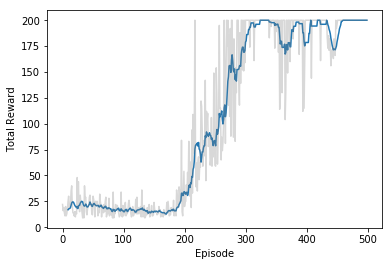

In [10]:
eps, rews = np.array(episode_reward_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha = 0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')